In [2]:
# Importing packages
import pandas as pd
import numpy as np
import matplotlib
import sklearn
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay


%matplotlib inline


# Setting up paths
First step is to setup files paths for the linguistics database and word2vec model made by Yang et al. 2020.

In [3]:
### Setting up relative file paths

# get current working directory
current_dir = Path.cwd()


# relative file path for linguistics database
data_file_rel_path = "../data/paper_data_streamlined.csv"

# make absolute path for linguistics database by combinig current working directory and relative path
data_path = (current_dir / data_file_rel_path).resolve()


# relative file path for word to vec model
model_rel_path = "../data/mag_200d_psy_eco_word2vec"

# make absolute path for word2vec model by combinig current working directory and relative path
model_path  = (current_dir / model_rel_path).resolve()

# Loading in linguistics database and word2vec model
The linguistics database is loaded in as the object "data", and the word2vec model is loaded in as "model".

In [4]:
#load in linguistics database
data = pd.read_csv(data_path, sep=',', names=['ID', 'bib', 'abstract', 'rep_score'])

# Removes some rows from the dataframe with NAs (remember that python starts counting from 0 . . .):
### CONSIDER MOVING TO R *
data.drop([0, 43, 92], axis = 0, inplace = True)

# Importing the word2vec model as a dataframe:
model = pd.read_csv(model_path, sep=' ', skiprows = 1, header=None)

# Calculate TF-IDF vectors for each paper
A TF-IDF vector is calculated for each documents in the collection. Each document is a abstract in the linguistics database, and the collection refers to the entire database of abstracts. 

This is done using the tfidfVectorizer function from scikit-learn. The vectors for each paper are saved as rows in a matrix. Each entry is the TF-IDF for a term in entire collection. Since many terms are not present in all documents, the resulting TF-IDFs will often be zero. The matrix is therefore saved as a sparse matrix, which is computationally more efficient. 


In [5]:
# Save the TF-IDF vectorizer function from sci-kit learn
tfidf = TfidfVectorizer()

# Make a sparse matrix containing TF-IDFs for each abstract. 
# This is done by passing the column containg Abstracts from the linguistics database to the vectorizer function. 
# Note that thext has be to converted to unicode strings. the text needs to be converted to unicode strings (see https://stackoverflow.com/questions/39303912/tfidfvectorizer-in-scikit-learn-valueerror-np-nan-is-an-invalid-document)
matrix = tfidf.fit_transform(data['abstract'].values.astype('U')) 


In [6]:
# Checking the vocabulary
tfidf.vocabulary_ # is the number the overall corpus frequency associated with each word?

{'in': 1148,
 'previous': 1781,
 'studies': 2243,
 'english': 793,
 'examining': 835,
 'the': 2334,
 'influence': 1184,
 'of': 1580,
 'phonological': 1699,
 'neighbourhood': 1522,
 'density': 642,
 'spoken': 2187,
 'word': 2557,
 'production': 1812,
 'words': 2558,
 'with': 2553,
 'many': 1393,
 'similar': 2126,
 'sounding': 2167,
 'or': 1609,
 'dense': 641,
 'were': 2531,
 'produced': 1810,
 'more': 1474,
 'quickly': 1859,
 'and': 185,
 'accurately': 97,
 'than': 2332,
 'few': 928,
 'sparse': 2172,
 'on': 1589,
 'process': 1804,
 'spanish': 2171,
 'was': 2519,
 'examined': 833,
 'picture': 1710,
 'naming': 1502,
 'task': 2312,
 'results': 1999,
 'showed': 2112,
 'that': 2333,
 'pictures': 1711,
 'names': 1501,
 'from': 987,
 'neighbourhoods': 1523,
 'named': 1499,
 'present': 1771,
 'pattern': 1663,
 'is': 1254,
 'opposite': 1606,
 'what': 2533,
 'has': 1048,
 'been': 309,
 'previously': 1782,
 'found': 972,
 'speech': 2180,
 'we': 2523,
 'hypothesise': 1102,
 'differences': 677,
 'mo

In [7]:
row = 5
col = tfidf.vocabulary_['syllabifying'] # how is the tfidf matrix structured?

print('Abstract: "%s"' % data.loc[row, 'ID'])
print('TF-IDF score: %f' % matrix[row, col])

print(matrix)
matrix.shape

print("Column number: ", col)

# So clearly, the data is there now . . . we just need to extract the right data in the matrix to do the next step

Abstract: "O4"
TF-IDF score: 0.000000
  (0, 1983)	0.07835154258702105
  (0, 2023)	0.07835154258702105
  (0, 150)	0.053564497424083576
  (0, 197)	0.07835154258702105
  (0, 33)	0.07835154258702105
  (0, 1906)	0.07074780697817605
  (0, 607)	0.07835154258702105
  (0, 1845)	0.07835154258702105
  (0, 1289)	0.06116823303292858
  (0, 2410)	0.03663291137378151
  (0, 1571)	0.05774913509840439
  (0, 1807)	0.041201585392734455
  (0, 555)	0.08374647885794773
  (0, 1408)	0.0562480846395736
  (0, 1576)	0.07416690491270024
  (0, 2366)	0.040345904593128395
  (0, 2321)	0.09135021446679273
  (0, 1524)	0.09135021446679273
  (0, 2536)	0.06314407136933106
  (0, 1362)	0.09135021446679273
  (0, 1482)	0.07835154258702105
  (0, 677)	0.1307057414144988
  (0, 1102)	0.09135021446679273
  (0, 2523)	0.034707825759721
  (0, 2180)	0.05014539948955939
  :	:
  (94, 1590)	0.172804509576423
  (94, 2521)	0.2434828720352746
  (94, 1552)	0.02994186966702364
  (94, 2349)	0.041681303328627
  (94, 1233)	0.04989083697013184
  (9

In [8]:
matrix.shape

(95, 2586)

## ====== pt. 2: importing the word2vec model and working with the dictionary file from the tf-idf =======


In [9]:
print(model.iloc[:,0]) # this is the column of works

0              the
1               of
2              and
3               in
4               to
            ...   
275556    workover
275557    condotel
275558      kuntey
275559       houga
275560      gp-stn
Name: 0, Length: 275561, dtype: object


In [10]:
# Defining dictionary as a data frame

# First, use dict.items() to get a group of the key-value pairs in the dictionary:

items = dict.items(tfidf.vocabulary_)

# Then, having this group as an object, use list(obj) to convert it to a list:

items = list(items)

# Finally, using this list as data, call numpy.array(data) to convert it to an array. But actually I want it to be a core pd data frame:

dict_df = pd.DataFrame(items)

print(dict_df)

print(type(dict_df))


                0     1
0              in  1148
1        previous  1781
2         studies  2243
3         english   793
4       examining   835
...           ...   ...
2581   phonologic  1698
2582          yes  2575
2583         _obe    67
2584  constitutes   526
2585   misleading  1448

[2586 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


In [11]:
# Renaming columns:

dict_df.columns = ['keys', 'values']

print(dict_df)


             keys  values
0              in    1148
1        previous    1781
2         studies    2243
3         english     793
4       examining     835
...           ...     ...
2581   phonologic    1698
2582          yes    2575
2583         _obe      67
2584  constitutes     526
2585   misleading    1448

[2586 rows x 2 columns]


In [12]:
# . . . and flipping the order:

column_titles = ['values', 'keys']
dict_df = dict_df.reindex(columns = column_titles)
print(dict_df)

      values         keys
0       1148           in
1       1781     previous
2       2243      studies
3        793      english
4        835    examining
...      ...          ...
2581    1698   phonologic
2582    2575          yes
2583      67         _obe
2584     526  constitutes
2585    1448   misleading

[2586 rows x 2 columns]


In [13]:
# Now we can index from the dataframe:

dict_df['keys'] # either extracting the entire column
dict_df['keys'][4] # or a single entry in a column
dict_df[['keys', 'values']] # how would I extract and entire row with data from both columns though?

# Link to indexing tips in Python: https://www.dataquest.io/blog/tutorial-indexing-dataframes-in-pandas/

,keys,values
0,in,1148
1,previous,1781
2,studies,2243
3,english,793
4,examining,835
...,...,...
2581,phonologic,1698
2582,yes,2575
2583,_obe,67
2584,constitutes,526


In [14]:
# Examining some attribrutes of the data:

print(dict_df.columns)
print(dict_df.index) # this is useful knowledge when wanting to construct the for loop


Index(['values', 'keys'], dtype='object')
RangeIndex(start=0, stop=2586, step=1)


The next task is to remove the words from the word2vec model (model) that do not appear in the dictionary (dict_df) and create a new model data-frame.

- One way to do this is by making a for-loop which goes through each row of our model dataframe, checking if there is a match with any of the words in the dictionaries. 

- If there is a match, the **word and its associated vector of dimensional values** should be added to a new two-column data-frame. 

- Ultimately, this data-frame will be as long as the dictionary, which should mean that it will be commensurable with the tf-idf matrix (elaborate).

> Make a plan for how to concretely design the for loop. Remember that we need to loop through the word2vec model for each word entry (row) in our dict_df!

In [15]:
dict_df.shape
model.shape

model.iloc[:,0]

0              the
1               of
2              and
3               in
4               to
            ...   
275556    workover
275557    condotel
275558      kuntey
275559       houga
275560      gp-stn
Name: 0, Length: 275561, dtype: object

In [16]:
# Trying out a for loop to extract terms from the model: 

# data 1 = dict_df 
# data 2 = model

# First we create an empty data frame to store the matched rows from the model
matched_df = pd.DataFrame(columns = model.columns)

# Then we create an empty dataframe to store the missing matches
missing_matches = pd.DataFrame(columns=['Term', 'Value'])

# We iterate through each term in the model:
for i, term in enumerate(dict_df['keys']):
    # Checking if the terms exists in the dictionary
    if term in model.iloc[:,0].values:
        # If there is a match, we extract the entire row from the model and add it to the matched_df
        row = model.loc[model.iloc[:,0] == term] # is this extracting the row?
        row.index = [i]
        matched_df = pd.concat([matched_df, row]) # how does this line work?
    else:
        # If no match is found, add the term to missing_matches
        missing_matches.loc[len(missing_matches)] = [term, dict_df.iloc[i, 0]]

matched_df = matched_df.sort_index()    

# Print missing matches
print("Missing Matches:")
print(missing_matches)

# Print the matched data frame
print("Matched Data Frame:")
print(matched_df)

type(matched_df)

Missing Matches:
                   Term  Value
0          syllabifying   2289
1              grosjean   1034
2       whethersubjects   2540
3              thiscase   2352
4             wordswere   2559
..                  ...    ...
80                 _eap     63
81  feedbackconsistency    920
82                  _ip     65
83                  _ob     66
84                 _obe     67

[85 rows x 2 columns]
Matched Data Frame:
              0         1         2         3         4         5         6     
0              in -0.227537  0.125394  0.097702 -0.155055 -0.133572  0.052193  \
1        previous -0.346380  0.006304  0.305970 -0.139675 -0.182512  0.049250   
2         studies -0.249250  0.010476  0.088974 -0.260289 -0.054414 -0.030271   
3         english -0.157916  0.097971  0.137283 -0.171298  0.103821  0.091728   
4       examining -0.314322  0.109868  0.144253 -0.049473 -0.119032 -0.173928   
...           ...       ...       ...       ...       ...       ...       ...   
2

pandas.core.frame.DataFrame

In [17]:
dict_df.iloc[:, 0]

0       1148
1       1781
2       2243
3        793
4        835
        ... 
2581    1698
2582    2575
2583      67
2584     526
2585    1448
Name: values, Length: 2586, dtype: int64

In [18]:
matched_df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,in,-0.227537,0.125394,0.097702,-0.155055,-0.133572,0.052193,0.143991,-0.084266,0.066472,...,0.125955,0.089060,-0.217870,-0.011854,-0.141282,0.020798,-0.082806,-0.056006,-0.044313,-0.163796
1,previous,-0.346380,0.006304,0.305970,-0.139675,-0.182512,0.049250,0.182775,-0.317705,0.238295,...,0.125932,-0.114897,-0.025431,0.251213,-0.250936,-0.024032,0.100205,0.017044,0.066197,0.045374
2,studies,-0.249250,0.010476,0.088974,-0.260289,-0.054414,-0.030271,0.194103,-0.325225,0.160901,...,0.087359,-0.130020,-0.146982,0.124166,-0.426162,-0.074545,0.017245,-0.096232,-0.001212,-0.059817
3,english,-0.157916,0.097971,0.137283,-0.171298,0.103821,0.091728,0.227996,-0.237087,0.038814,...,0.054863,0.129875,-0.239072,0.025619,0.082328,0.073301,0.082712,0.122293,0.147350,-0.081697
4,examining,-0.314322,0.109868,0.144253,-0.049473,-0.119032,-0.173928,0.266191,-0.290743,0.030236,...,0.061207,-0.060738,-0.196720,0.074695,-0.264687,-0.032342,-0.036688,0.044775,0.161296,-0.184259


In [19]:
dict_df.head()

,values,keys
0,1148,in
1,1781,previous
2,2243,studies
3,793,english
4,835,examining


## ========== next step: remove missing words from TF_IDF matrix ========

In [20]:
# Checking some dimensions of the objects of interest:

print("Missing matches list dimensions: ", missing_matches.shape)
print("Dimensions of the new model data frame: ", matched_df.shape)
print("Dimensions of the TF-IDF matrix: ", matrix.shape)

Missing matches list dimensions:  (85, 2)
Dimensions of the new model data frame:  (2501, 201)
Dimensions of the TF-IDF matrix:  (95, 2586)


In [21]:
print(missing_matches)
# print(missing_matches['Index'])

print(dict_df.iloc[164, :])

                   Term  Value
0          syllabifying   2289
1              grosjean   1034
2       whethersubjects   2540
3              thiscase   2352
4             wordswere   2559
..                  ...    ...
80                 _eap     63
81  feedbackconsistency    920
82                  _ip     65
83                  _ob     66
84                 _obe     67

[85 rows x 2 columns]
values         1350
keys      listeners
Name: 164, dtype: object


Reflection pad:

- We want to modify the for loop creating the matched_df to also output the index for the missing matches

- Then, we can use this information to remove the corresponding columns from the TF-IDF

**FINALLY** we are ready to somehow (?) multiply the two matrices. 

- We want the output to have one number for each abstract - that's all!

In [22]:
missing_matches['Value']

0     2289
1     1034
2     2540
3     2352
4     2559
      ... 
80      63
81     920
82      65
83      66
84      67
Name: Value, Length: 85, dtype: int64

In [23]:
# Converting the TF-IDF matrix to panda pd

tf_idf_df = pd.DataFrame.sparse.from_spmatrix(matrix)

#print(tf_idf_df.shape)

# Removing the columns contained in the missing_matches['Value']

# Converting missing_matches['Value']

type(missing_matches['Value'])

missing_matches_list = list(missing_matches['Value'])
print(missing_matches_list)

# Sort tf-idf matrix and remove the columns corresponding to the values contained in the missing_matches list:

tf_idf_matched_df = tf_idf_df[tf_idf_df.columns[~tf_idf_df.columns.isin(missing_matches_list)]]


[2289, 1034, 2540, 2352, 2559, 411, 2364, 1757, 1076, 1852, 1661, 34, 53, 62, 1697, 926, 2288, 1957, 1263, 2469, 1261, 2506, 1490, 798, 1479, 1447, 1337, 2194, 235, 237, 970, 2577, 2486, 2374, 657, 901, 1084, 1620, 2482, 1583, 756, 755, 2483, 754, 161, 322, 1098, 1099, 1503, 2255, 2443, 2052, 1861, 2190, 1075, 1290, 878, 2489, 1319, 1540, 1592, 2335, 346, 2070, 2189, 1024, 344, 603, 724, 2188, 1666, 2378, 1338, 2227, 2228, 1097, 1096, 1638, 1581, 64, 63, 920, 65, 66, 67]


In [24]:
type(tf_idf_df)

pandas.core.frame.DataFrame

# ===== Reindexing and alligning matrices ======

In [25]:
# Reindexing the 'matched' word2vec dataframe

word2vec_rindx = matched_df.iloc[:, 1:] # Removing the first column (with the actual words)
word2vec_rindx = word2vec_rindx.reset_index(drop = True) # Reindexing
word2vec_rindx.columns = range(len(word2vec_rindx.columns)) # . . . and changing the index range to 0-199

print(word2vec_rindx)
type(word2vec_rindx)

           0         1         2         3         4         5         6     
0    -0.227537  0.125394  0.097702 -0.155055 -0.133572  0.052193  0.143991  \
1    -0.346380  0.006304  0.305970 -0.139675 -0.182512  0.049250  0.182775   
2    -0.249250  0.010476  0.088974 -0.260289 -0.054414 -0.030271  0.194103   
3    -0.157916  0.097971  0.137283 -0.171298  0.103821  0.091728  0.227996   
4    -0.314322  0.109868  0.144253 -0.049473 -0.119032 -0.173928  0.266191   
...        ...       ...       ...       ...       ...       ...       ...   
2496 -0.021529 -0.040331  0.093697  0.071710  0.295056 -0.512503  0.023171   
2497  0.166119  0.011583  0.617321  0.059052 -0.167412  0.449738  0.174121   
2498 -0.035224 -0.060090  0.592755 -0.317422 -0.246039  0.318855  0.028493   
2499 -0.191645  0.074492  0.268575 -0.336695 -0.071241 -0.189615  0.052777   
2500 -0.356981 -0.131151  0.376909 -0.188344 -0.202470  0.300605  0.007481   

           7         8         9    ...       190       191    

pandas.core.frame.DataFrame

In [26]:
# Doing the same for the tf_idf.matched dataframe:

tf_idf_rindx = tf_idf_matched_df.reset_index(drop = True) # Reindexing
tf_idf_rindx.reset_index(drop = True, inplace = True) # . . . and changing the index range to 0-199

print(tf_idf_rindx)
type(tf_idf_rindx)

    0     1     2     3     4     5     6     7     8     9     ...      2575   
0    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000  \
1    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
2    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
3    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
4    0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
..   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...       ...   
90   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
91   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
92   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
93   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.000000   
94   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  ...  0.085085   

    2576  2578  2579  2580 

pandas.core.frame.DataFrame

In [27]:
# Checking type and dimensions of our two dataframes:

print("Dimensions of the TF-IDF dataframe: ", tf_idf_rindx.shape)
print("Type of TF-IDF dataframe: ", type(tf_idf_rindx))
print(" ")
print("Dimensions of the word2vec dataframe: ", word2vec_rindx.shape)
print("Type of word2vec dataframe: ", type(word2vec_rindx))


Dimensions of the TF-IDF dataframe:  (95, 2501)
Type of TF-IDF dataframe:  <class 'pandas.core.frame.DataFrame'>
 
Dimensions of the word2vec dataframe:  (2501, 200)
Type of word2vec dataframe:  <class 'pandas.core.frame.DataFrame'>


# ======= Multiplying the matrices: TF-IDF x Word2Vec ======

In [28]:
# For matrices to be commensurable in a multiplication: 
# X * Y, the number of columns of X needs to correspond to the number of rows in Y

# Fortunately, the number of colums in the TF-IDF dataframe (98, 2510) is the same as the
# as the number of rows in the word2vec dataframe (2510, 200). 

# Mathematically, it should not be a problem to multiply the two:

#product = tf_idf_rindx.dot(word2vec_rindx) 
# This does not work. We can try to use numpy?

print(type(tf_idf_rindx))

tf_idf_rindx_np = tf_idf_rindx.to_numpy() # Remember this parenthesis!

print(type(tf_idf_rindx_np))

word2vec_rindx_np = word2vec_rindx.to_numpy()

print(type(word2vec_rindx_np))


<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
# Re-attempting the multiplication with numpy methods: 

tf_idf_w2v_product = np.matmul(tf_idf_rindx_np, word2vec_rindx_np)

print("Product shape: ", tf_idf_w2v_product.shape, "Product type: ", type(tf_idf_w2v_product))

Product shape:  (95, 200) Product type:  <class 'numpy.ndarray'>


# ====== Status update =======

1. Create a similar matrix, using tf instead of tf_idf:

    - Everything should be the same, only the input matrix should contain pure tf's instead of tf-idf's
    
    - We can reuse the script from pt. 1 and change one command?

In [30]:
# 1. Computing term frequencies:

# data_file = '/Users/christianstenbro/Programming/ripley_project/Data_files/original_paper_data_frame_cleaned_v1.csv'
# data = pd.read_csv(data_file, sep=',', names=['ID', 'bib', 'abstract', 'rep_score'])
# data.head()

vectorizer = CountVectorizer() # The CountVectorizer converts a text corpus (here our collection of abstracts in 'data) to a matrix of 'token counts' = term frequencies (tf).
matrix_tf = vectorizer.fit_transform(data['abstract'].values.astype('U'))

print("TF-matrix dimensions: ", matrix_tf.shape, "TF-matrix object type: ", type(matrix_tf))

TF-matrix dimensions:  (95, 2586) TF-matrix object type:  <class 'scipy.sparse._csr.csr_matrix'>


In [31]:
vectorizer.vocabulary_ # And this matches the vocab of the tf_idf matrix:

print("Are the vocabularies of the tf and tfidf matrices identical? Output:", vectorizer.vocabulary_ == tfidf.vocabulary_)

Are the vocabularies of the tf and tfidf matrices identical? Output: True


This means that we can use the exact same methods to process the tf-matrix as we already used for the tf-idf matrix!

In [32]:
# We already have the missing matches list from previously:

missing_matches_list # The column index for the terms in the abstract matrix not present in the word2vec model. 
# These will be extracted from the tf-matrix as well to make it commensurable with the word2vec model matrix:

# First, we convert the tf-matrix from a sparse matrix to a pd.DataFrame:

tf_df = pd.DataFrame.sparse.from_spmatrix(matrix_tf)

# Then we remove the columns correponding to the missing words in the word2vec model:

tf_matched_df = tf_df[tf_df.columns[~tf_df.columns.isin(missing_matches_list)]]

print("Dimensions of tf_matched_df: ", tf_matched_df.shape)

Dimensions of tf_matched_df:  (95, 2501)


In [33]:
# Finally, we reindex the dataframe and convert it to a numpy array:

tf_rindx = tf_matched_df.reset_index(drop = True) # Reindexing
tf_rindx.reset_index(drop = True, inplace = True) # . . . and changing the index range to 0-199

# print(tf_rindx) # One wonders if it actually contains any numbers?
# type(tf_rindx)

tf_rindx_np = tf_rindx.to_numpy()

In [34]:
# Again, we can check if the matrices are commensurable: 

print("Dimensions of the TF dataframe: ", tf_rindx_np.shape)
print("Type of TF dataframe: ", type(tf_rindx_np))
print(" ")
print("Dimensions of the word2vec dataframe: ", word2vec_rindx_np.shape)
print("Type of word2vec dataframe: ", type(word2vec_rindx_np))
print(" ")
print("Are the matrices commensurable? Output:", len(tf_rindx_np[0]) == len(word2vec_rindx_np))

# print(len(tf_rindx_np[0])) # Strange way of finding the column and row numbers, at least compared to R. 
# print(len(word2vec_rindx_np))

# Notice that 'array[0]' is the second dimension of the array while (columns), while 'array' is simply the first dimension (rows).

Dimensions of the TF dataframe:  (95, 2501)
Type of TF dataframe:  <class 'numpy.ndarray'>
 
Dimensions of the word2vec dataframe:  (2501, 200)
Type of word2vec dataframe:  <class 'numpy.ndarray'>
 
Are the matrices commensurable? Output: True


# ====== Multiplying matrices: TF x Word2Vec ========

In [35]:
# With everything in place, we can multiply the matrices using the np.matmul function: 

tf_w2v_product = np.matmul(tf_rindx_np, word2vec_rindx_np)

print("Product shape: ", tf_w2v_product.shape, "Product type: ", type(tf_w2v_product))

Product shape:  (95, 200) Product type:  <class 'numpy.ndarray'>


Finally, we have our two matrices.

But how do we actually conceptualize what these matrices consist of?

# ==== Appending ground truth encodings =======

In [36]:
# Create columns of replication outcomes from data_set:

rep_column = (data['rep_score'])

rep_column = rep_column.to_numpy()

print(rep_column)


['yes' 'partial' 'partial' 'yes' 'no' 'no' 'yes' 'yes' 'yes' 'yes' 'yes'
 'yes' 'yes' 'no' 'yes' 'yes' 'partial' 'yes' 'yes' 'yes' 'yes' 'yes'
 'yes' 'yes' 'yes' 'partial' 'yes' 'yes' 'no' 'no' 'yes' 'yes' 'partial'
 'yes' 'yes' 'partial' 'yes' 'no' 'no' 'yes' 'no' 'partial' 'yes' 'yes'
 'yes' 'yes' 'yes' 'yes' 'partial' 'no' 'partial' 'yes' 'yes' 'yes' 'yes'
 'yes' 'yes' 'no' 'no' 'no' 'yes' 'partial' 'partial' 'yes' 'yes' 'no'
 'yes' 'yes' 'yes' 'no' 'yes' 'yes' 'yes' 'yes' 'yes' 'partial' 'no' 'no'
 'no' 'yes' 'yes' 'no' 'yes' 'no' 'no' 'yes' 'partial' 'partial' 'yes'
 'yes' 'yes' 'no' 'no' 'yes' 'yes']


In [37]:
# Creating a for loop replacing the 'yes/partial' with 1 and 'no' with 0 to obtain a binary outcome variable:

for i, val in enumerate(rep_column):
    if val == "yes" or i == "partial":
        rep_column[i] = 1
    else:
        rep_column[i] = 0

print(rep_column)
print(rep_column.shape)

[1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 1 1 0 1
 0 0 1 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 0 1 1 0 1 1 1 0 1 1 1 1
 1 0 0 0 0 1 1 0 1 0 0 1 0 0 1 1 1 0 0 1 1]
(95,)


In [38]:
# Append outcomes to tf-idf * w2v product matrix:

tf_idf_w2v_encoded = np.c_[ tf_idf_w2v_product, rep_column ]

tf_idf_w2v_encoded.shape

tf_idf_w2v_encoded = pd.DataFrame(tf_idf_w2v_encoded)

# Repeating the process for the tf matrix:
tf_w2v_encoded = np.c_[ tf_w2v_product, rep_column ]

tf_w2v_encoded = pd.DataFrame(tf_w2v_encoded)

In [39]:
tf_idf_w2v_encoded.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,200
0,-2.058452,0.368673,1.376803,-1.405207,-0.79821,0.603758,0.901007,-0.033724,1.251318,1.045505,...,-0.123619,0.099695,0.266947,-0.754666,-0.445982,0.162899,-0.791294,0.261159,-1.3706,1
1,-1.822499,0.479263,1.476353,-1.188719,-0.748568,0.445022,0.899538,-0.196,1.115131,0.828692,...,0.005808,-0.488914,0.242612,-0.90916,-0.18543,0.313198,-0.485337,0.047452,-1.002884,0
2,-1.598499,0.606412,1.276193,-0.908887,-0.666337,0.483357,0.78959,-0.223053,1.028562,0.482812,...,-0.171464,-0.255339,0.376435,-0.702043,-0.152599,0.046016,-0.341507,-0.067445,-1.158638,0
3,-1.225319,0.339557,0.772748,-0.930528,-0.498734,-0.022198,0.520734,-0.158833,0.830174,0.537449,...,0.084208,-0.372784,0.174391,-0.667464,0.09056,-0.13596,-0.228646,0.039193,-0.856355,1
4,-1.598499,0.606412,1.276193,-0.908887,-0.666337,0.483357,0.78959,-0.223053,1.028562,0.482812,...,-0.171464,-0.255339,0.376435,-0.702043,-0.152599,0.046016,-0.341507,-0.067445,-1.158638,0


Final matrices:

- tf_w2v_encoded

- tf_idf_w2v_encoded 

# ====== Training fixed seed model =======

In [40]:
# Split the dataset into features and target
y = tf_idf_w2v_encoded.iloc[:, 200] # Target
y = pd.get_dummies(y)
X = tf_idf_w2v_encoded.iloc[:, :200] # Features

# Check frequencies for the different outcomes in the dataset
print(y.value_counts())

0      1    
False  True     59
True   False    36
Name: count, dtype: int64


In [41]:
# Splitting the data-set into a train and test set using fixed seed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Making the model print its parameters
sklearn.set_config(print_changed_only=False)

# Instantiating the Random Forest Classifier with fixed seed
forest = RandomForestClassifier(max_depth=3, random_state=42)

# And training the model via .fit()
clf = forest.fit(X_train, y_train)

# Obtaining accuracy score by comparing predicitions and actual score
y_pred_test = clf.predict(X_test)
print("Accuracy Score = ", accuracy_score(y_test, y_pred_test)) 

Accuracy Score =  0.71875


While the accuracy is not very impressive, it is not the only measure of how well the model actually performs. According to [Kreiger](https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56), we can use a confusion matrix to get more information about our model – how well does it classify the different classes?

## Evaluating the fixed seed model: Computing Confusion Matrix, F1 score, and ROC

### a. Drawing confusion matrix

In [42]:
# Converting the y_pred_test to dataframe
y_pred_test = pd.DataFrame(y_pred_test)

# Converting both the prediction and the true outcomes to binary strings
print(y_test.values.argmax(axis=1))
print(y_pred_test.values.argmax(axis=1))

[1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0]
[0 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0]


[[ 4  4]
 [ 5 19]]


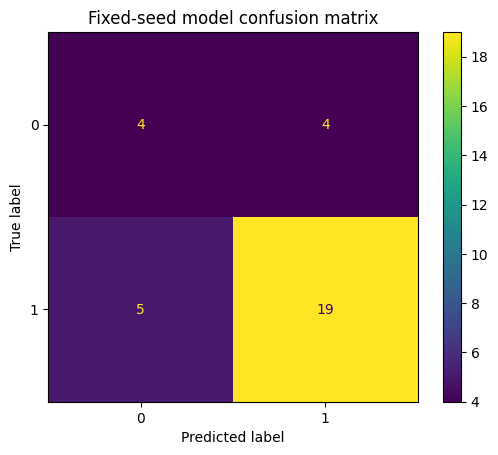

In [43]:
# Making confusion matrix
print(confusion_matrix(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))) 
# The inputs are converted to binary strings using the argmax along axis 1

# We can also try out another matrix with actual labels, making the confusion matrix less . . . confusing:
ConfusionMatrixDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))
plt.title("Fixed-seed model confusion matrix")
plt.show()


How do we interpret the confusion matrix?

- The upper left corner contains the true negatives (correctly rejected negative outcomes).
- The lower left corner contains the false negatives (type 2 errors). 

Since there are four instances in each, the model can be said, with this seed, to be no better than random at prediction true negatives. 
This is a problem since a likely use-case of a replication prediction model would be to flag studies likely to not replicate (is this ability called precision?).

It performs better in predicting positive outcomes: 
- The lower left corner shows the type 1 errors, or false positives. 
- The lower right corner shows the true positives, or hits. 

As evident from the matrix, the larger part of the positive predictions turned out to be true positives.


In [44]:
# Checking the distribution of true positive/negative values in the test set to varify the findings of the confusion matrix: 
print("True positive and negative outcomes in the test set: ", y_test.values.argmax(axis=1))

True positive and negative outcomes in the test set:  [1 1 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 0]


### b. Drawing ROC for the classifier, compared to random guess line

In [45]:
# Trying to make the ROC manually (failed attempt).

#y_pred_prob = clf.predict_proba(X_test)
#print(len(y_pred_prob[0]))
#print(y_pred_prob[0])

#print(y_test)


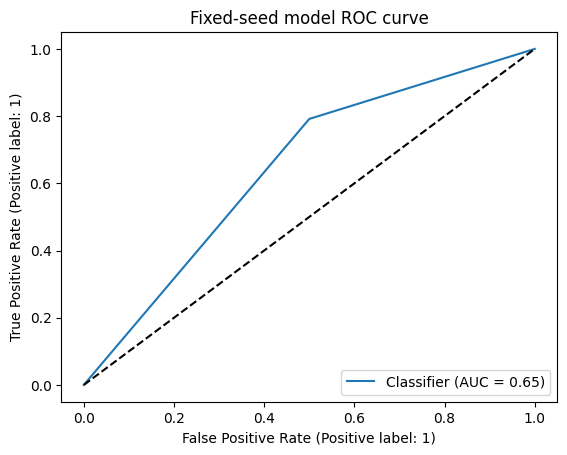

In [46]:
# ROC curve from predictions (looks weird, like a v)
RocCurveDisplay.from_predictions(y_test.values.argmax(axis=1), y_pred_test.values.argmax(axis=1))
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title("Fixed-seed model ROC curve")
plt.show()


### c. Creating classification report including F1 score

In [47]:
# Printing the classification report to obtain f1-score
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.44      0.50      0.47         8
           1       0.83      0.79      0.81        24

   micro avg       0.72      0.72      0.72        32
   macro avg       0.64      0.65      0.64        32
weighted avg       0.73      0.72      0.72        32
 samples avg       0.72      0.72      0.72        32



# ====== Training model with random split test-training subsets 1000 times to estimate the distribution of trained model performance  =======

In [48]:
# Making a baseline dummy model predicting only successful replications and comparing it with the trained model:

# Make a matrix of n-rows (corresponding to the length of y_test) with [0 1] in each row.
dummy_model_0 = np.full((len(y_test),1), 0)
dummy_model_1 = np.full((len(y_test), 1), 1)
dummy_model = np.hstack((dummy_model_0, dummy_model_1))

# Converting to panda dataframe to match the format of the y_test results
dummy_model_pd = pd.DataFrame(dummy_model)

# Printing the accuracy scores of the dummy model and the actual model: 
print("Accuracy Score of Dummy model = ", accuracy_score(y_test, dummy_model_pd)) 
print("Accuracy Score of Actual model = ", accuracy_score(y_test, y_pred_test))

Accuracy Score of Dummy model =  0.75
Accuracy Score of Actual model =  0.71875


In [49]:
# Making the model print its parameters
sklearn.set_config(print_changed_only=False)

# Instantiating the Random Forest Classifier
forest = RandomForestClassifier(max_depth=3)

#empty list of observed accuraices
accuracies = []
dummy_accuracy_list = []

#make a new train-test split and test accuracy
for i in range (1000) :
    # Make train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    # train model for each iteration
    forest.fit(X_train, y_train)
    # generate predictions
    y_pred_test = forest.predict(X_test)
    # score predicitons
    accuracy = accuracy_score(y_test, y_pred_test)
    # save accurcy score to list
    accuracies.append(accuracy)
    # save dummy list accuracies
    dummy_accuracy_list.append(accuracy_score(y_test, dummy_model_pd))


In [50]:
#turn list of accuracies into dataframe
accuracies_df = pd.DataFrame(list(zip(accuracies, dummy_accuracy_list)), index=None)
accuracies_df.columns = ['accuracy', 'dummy accuracy']

#save to .csv for visualization in r (commented out)
#accuracies_df.to_csv("../data/accuracies.csv")

print("Mean trained model accuracy: ",np.mean(accuracies))
print("Mean dummy accuracy: ", np.mean(dummy_accuracy_list))

Mean trained model accuracy:  0.6044375
Mean dummy accuracy:  0.62015625
